## 1. Import libraries and requirements

In [1]:
# Loading required packages
import spacy
import pandas as pd
import re
import gensim
import gensim.downloader
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import nltk
from numpy import mean
from numpy import std
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from statistics import mean
import json
import csv
import ast
import numpy as np

from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings

from tqdm import tqdm

# Set seed
seed = np.random.seed(1)


# Select Spacy model
# Efficiency
nlp = spacy.load("en_core_web_sm")

# Accuracy
# nlp = spacy.load("en_core_web_trf")

# Change working directory
# %cd '/Users/richardfrissen/Documents/Maastricht University/Thesis/Development/Datasets'

/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
# Define columns and read annotated data
columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'like_num', 'lang', 'sentiment']
data = pd.read_csv('FULL_Annotation_data_output.tsv', sep='\t')#, nrows=500000, header = None)

In [ ]:
%%time

# Generate linguistic features for each token
def feature_extraction(input_column):
    features = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for i in tqdm(input_column):
        i = str(i)
        doc = nlp(i)
        word = i
        for token in doc:
            features[0].append(token.pos)
            features[1].append(token.ent_type)
            features[2].append(token.is_alpha)
            features[3].append(token.is_ascii)
            features[4].append(token.is_digit)
            features[5].append(token.is_lower)
            features[6].append(token.is_upper)
            features[7].append(token.is_title)
            features[8].append(token.is_punct)
            features[9].append(token.is_space)
            features[10].append(token.like_num)
            features[11].append(token.is_oov)
            features[12].append(token.is_stop)
            features[13].append(token.lang)
            features[14].append(token.sentiment)
            features[15].append(len(word))
    return features

features = feature_extraction(data[0])

In [ ]:
%%time

# Convert list to dataframe
features = pd.DataFrame(features)

# We need to transpose this dataframe first
features = features.transpose()

# We concat the annotated data with the linguistic features
data = pd.concat([data, features], axis=1)
data.columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'lang', 'sentiment', 'word_length']

data.head(10)

In [1]:
# Optionally the data can be saved to create a checkpoint

# data.to_csv('data_features_full_dataset.csv', index = False)

data = pd.read_csv('data_features_full_dataset.csv', nrows = 500000, header = 0)

data.shape

In [ ]:
data.head(10)

In [12]:
# init word embedding
embedding = WordEmbeddings('glove')

In [ ]:
%%time

def glove_wordembed(input_column):
    glove_result =[]
    counter = 0
    for i in tqdm(input_column):
        counter = counter +1
        try:
            i = str(i)
            token = Sentence(i)
            embedding.embed(token)
            for token in token:
                result_array = token.embedding
            result_list = result_array.tolist()
            glove_result.append(result_list)
        except KeyError:
            glove_result.append(np.nan)
        except TypeError: 
            glove_result.append(np.nan)
        except IndexError:
            glove_result.append(np.nan)

    return glove_result


# GloVe_Word_Embeddings
word_embedding = glove_wordembed(data['Token'])

In [ ]:
len(word_embedding)

In [ ]:
# Optionally the data can be saved to create a checkpoint

import pickle

f = open('word_embedding_glove.pckl', 'wb')
pickle.dump(word_embedding, f)
f.close()

f = open('word_embedding_glove.pckl', 'rb')
word_embedding = pickle.load(f)
f.close()

In [ ]:
%%time

# Replace empty values in the list of word embeddings for words 
# we couldn't generate a word embedding for

word_embedding_complete = []

for i in tqdm(word_embedding):
    try:
        if len(i) == 0:
            i = []
        else:
            i = i
        word_embedding_complete.append(i)
        
    except TypeError:
        i = []
        word_embedding_complete.append(i)

In [ ]:
# Check and verify length
# Length must be the same as the nrows of the dataframe

len(word_embedding_complete)

In [ ]:
%%time

# Convert list to dataframe
word_embedding_df = pd.DataFrame(word_embedding_complete)
word_embedding_series = word_embedding_df.apply(pd.Series)

# We concat the annotated data with the linguistic features
data = pd.concat([data, word_embedding_series], axis=1)

In [ ]:
data.head(10)

In [7]:
%%time

# Optionally the data can be saved to create a checkpoint

# data.to_csv('data_features_full_wordembedding_glove.csv', index = False)

data = pd.read_csv('data_features_full_wordembedding_glove.csv'), nrows = 500000, na_values=['nan'])

data.head(10)

CPU times: user 1.73 s, sys: 96.6 ms, total: 1.83 s
Wall time: 1.84 s


,Token,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,is_punct,is_space,like_num,is_oov,is_stop,lang,sentiment,word_length,0
0,food,O,92,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,4,-0.164860
1,a,O,90,0,True,True,False,True,False,False,False,False,False,True,True,14626626061804382878,0.0,1,-0.270860
2,fast,O,86,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,4,-0.294280
3,grow,O,100,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,4,-0.128200
4,-winne,O,97,0,False,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,6,-0.130350
5,online,O,86,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,6,0.124870
6,food,O,92,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,4,-0.164860
7,community,O,92,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,9,0.370750
8,and,O,89,0,True,True,False,True,False,False,False,False,False,True,True,14626626061804382878,0.0,3,-0.071953
9,crowd,O,92,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,5,0.325750


In [3]:
%%time

# Replace NaN values with a "0"

data = data.replace(np.nan, '0', regex=True)

# We drop the token, as it is no longer needed for prediction
data.drop('Token', axis=1, inplace=True)
data.head(10)

CPU times: user 91.9 ms, sys: 13.1 ms, total: 105 ms
Wall time: 105 ms


,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,is_punct,is_space,like_num,is_oov,is_stop,lang,sentiment,word_length,0
0,O,92,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,4,-0.164860
1,O,90,0,True,True,False,True,False,False,False,False,False,True,True,14626626061804382878,0.0,1,-0.270860
2,O,86,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,4,-0.294280
3,O,100,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,4,-0.128200
4,O,97,0,False,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,6,-0.130350
5,O,86,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,6,0.124870
6,O,92,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,4,-0.164860
7,O,92,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,9,0.370750
8,O,89,0,True,True,False,True,False,False,False,False,False,True,True,14626626061804382878,0.0,3,-0.071953
9,O,92,0,True,True,False,True,False,False,False,False,False,True,False,14626626061804382878,0.0,5,0.325750


In [4]:
%%time

# 80% / 20% split
# Train, Test = train_test_split(data1, test_size=0.2, shuffle=False)

X = data.drop(['Label'],axis=1).values # independant features
y = data['Label'].values # dependant variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

CPU times: user 179 ms, sys: 104 ms, total: 283 ms
Wall time: 284 ms


In [5]:
# Delete data to save memory

del(data)

In [6]:
X_train.shape, y_train.shape

((400000, 17), (400000,))

In [7]:
X_test.shape, y_test.shape

((100000, 17), (100000,))

In [8]:
%%time

max_iterations = 1000000000

classifier = []
accuracy = []
precision = []
recall = []
f1 = []

CPU times: user 4 µs, sys: 9 µs, total: 13 µs
Wall time: 23.1 µs


In [9]:
%%time
# Baseline

clf = DummyClassifier(strategy="uniform", random_state=seed)


# Model fit
clf.fit(X_train, y_train)

CPU times: user 347 µs, sys: 444 µs, total: 791 µs
Wall time: 721 µs


DummyClassifier(strategy='uniform')

In [27]:
# Optionally the data can be saved to create a checkpoint - Baseline

import pickle

f = open('glove_baseline.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('glove_baseline.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.16914
Precision: 0.16726529085124733
Recall: 0.17297909299630665
F1_score: 0.05925786002208041


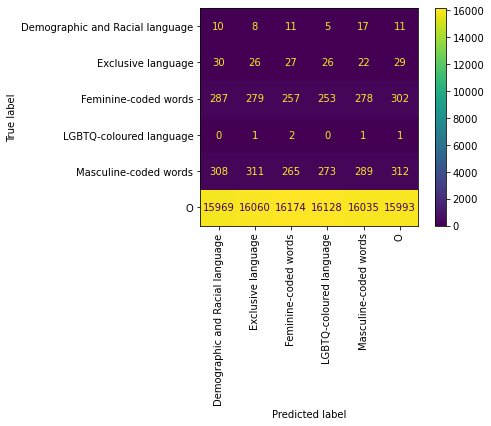

                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.16      0.00        62
             Exclusive language       0.00      0.17      0.00       160
           Feminine-coded words       0.02      0.16      0.03      1656
        LGBTQ-coloured language       0.00      0.20      0.00         5
          Masculine-coded words       0.02      0.18      0.03      1758
                              O       0.97      0.17      0.29     96359

                       accuracy                           0.17    100000
                      macro avg       0.17      0.17      0.06    100000
                   weighted avg       0.93      0.17      0.28    100000



In [28]:
# Evaluation Baseline

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("Baseline")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [9]:
%%time

# Find optimal SVM parameters

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': ('linear', 'rbf', 'poly', 'sigmoid')}
# grid_search = GridSearchCV(svm.SVC(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

CPU times: user 3 µs, sys: 8 µs, total: 11 µs
Wall time: 20.3 µs


In [9]:
%%time
# Support Vector Machine
# best: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = svm.SVC(kernel='rbf', random_state=seed, max_iter=max_iterations, C=10, gamma=1, probability=True)
# scores_SVM = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
# SVM_avg_precision = mean(scores_SVM['test_precision_macro'])
# SVM_avg_recall = mean(scores_SVM['test_recall_macro'])
# SVM_avg_f1 = mean(scores_SVM['test_f1_macro'])

# print(SVM_avg_precision)
# print(SVM_avg_recall)
# print(SVM_avg_f1)

# Model fit
clf.fit(X_train, y_train)

CPU times: user 1h 58min 44s, sys: 19.7 s, total: 1h 59min 3s
Wall time: 2h 1min


SVC(C=10, gamma=1, max_iter=1000000000, probability=True)

In [10]:
# Optionally the data can be saved to create a checkpoint - SVM

import pickle

f = open('glove_svm_prob.pckl', 'wb')
pickle.dump(clf, f)
f.close()

# f = open('glove_svm.pckl', 'rb')
# clf = pickle.load(f)
# f.close()

Accuracy: 0.09381
Precision: 0.16973161868568432
Recall: 0.20164227406875793
F1_score: 0.04202983509645299


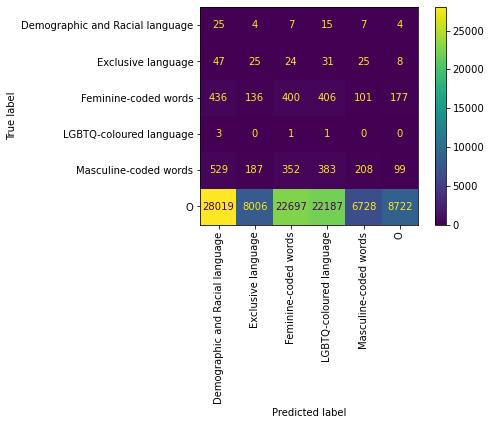

                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.40      0.00        62
             Exclusive language       0.00      0.16      0.01       160
           Feminine-coded words       0.02      0.24      0.03      1656
        LGBTQ-coloured language       0.00      0.20      0.00         5
          Masculine-coded words       0.03      0.12      0.05      1758
                              O       0.97      0.09      0.17     96359

                       accuracy                           0.09    100000
                      macro avg       0.17      0.20      0.04    100000
                   weighted avg       0.93      0.09      0.16    100000



In [30]:
# Evaluation Support Vector Machine

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("SVM")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal Logistic Regression settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# penaltys = ['l1', 'l2', 'elasticnet']
# param_grid = {'C': Cs, 'penalty' : penaltys, 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
# grid_search = GridSearchCV(LogisticRegression(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [13]:
%%time

# Logistic Regression

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = LogisticRegression(solver='newton-cg', random_state=seed, max_iter=max_iterations)
scores_LR = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
LR_avg_precision = mean(scores_LR['test_precision_macro'])
LR_avg_recall = mean(scores_LR['test_recall_macro'])
LR_avg_f1 = mean(scores_LR['test_f1_macro'])

print(LR_avg_precision)
print(LR_avg_recall)
print(LR_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not

0.16036208333333332
0.16666666666666666
0.16345360393227235
CPU times: user 8min 54s, sys: 40min 9s, total: 49min 4s
Wall time: 2min 14s


/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


LogisticRegression(max_iter=1000000000, solver='newton-cg')

In [31]:
# Optionally the data can be saved to create a checkpoint - LR

import pickle

f = open('glove_lr.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('glove_lr.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.96359
Precision: 0.16059833333333332
Recall: 0.16666666666666666
F1_score: 0.1635762387599584


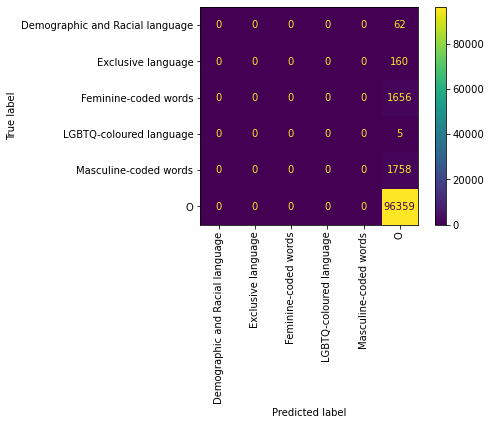

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.00      0.00      0.00      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       0.96      1.00      0.98     96359

                       accuracy                           0.96    100000
                      macro avg       0.16      0.17      0.16    100000
                   weighted avg       0.93      0.96      0.95    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Evaluation Logistic Regression

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("LR")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [16]:
%%time

# Decision Tree

# Cross validation
scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = DecisionTreeClassifier(random_state=seed)
scores_DT = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
DT_avg_precision = mean(scores_DT['test_precision_macro'])
DT_avg_recall = mean(scores_DT['test_recall_macro'])
DT_avg_f1 = mean(scores_DT['test_f1_macro'])

print(DT_avg_precision)
print(DT_avg_recall)
print(DT_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9016212495156927
0.9166114976708793
0.9062486128243803
CPU times: user 5.35 s, sys: 490 ms, total: 5.84 s
Wall time: 10.1 s


DecisionTreeClassifier()

In [33]:
# Optionally the data can be saved to create a checkpoint - DT

import pickle

f = open('glove_dt.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('glove_dt.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.99623
Precision: 0.9258475018912903
Recall: 0.8917397039784517
F1_score: 0.8999671711343354


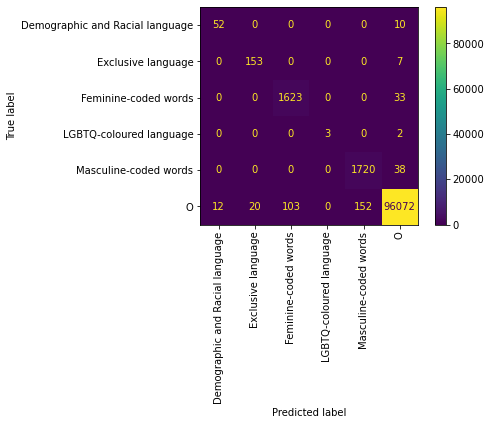

                                 precision    recall  f1-score   support

Demographic and Racial language       0.81      0.84      0.83        62
             Exclusive language       0.88      0.96      0.92       160
           Feminine-coded words       0.94      0.98      0.96      1656
        LGBTQ-coloured language       1.00      0.60      0.75         5
          Masculine-coded words       0.92      0.98      0.95      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       0.93      0.89      0.90    100000
                   weighted avg       1.00      1.00      1.00    100000



In [34]:
# Evaluation Decision Tree

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("DT")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [19]:
%%time

# Random Forest

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = RandomForestClassifier(random_state=seed)
scores_RF = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
RF_avg_precision = mean(scores_RF['test_precision_macro'])
RF_avg_recall = mean(scores_RF['test_recall_macro'])
RF_avg_f1 = mean(scores_RF['test_f1_macro'])

print(RF_avg_precision)
print(RF_avg_recall)
print(RF_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.695262981700806
0.6475290970669793
0.6651157215295407
CPU times: user 1min, sys: 741 ms, total: 1min 1s
Wall time: 2min 2s


RandomForestClassifier()

In [35]:
# Optionally the data can be saved to create a checkpoint - RF

import pickle

f = open('glove_rf.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('glove_rf.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.98696
Precision: 0.7327249403734926
Recall: 0.656070749935037
F1_score: 0.6880362696096834


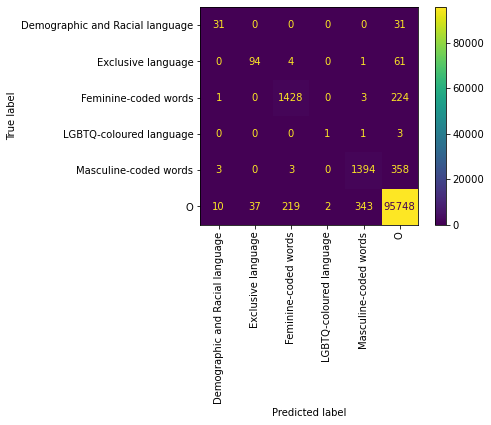

                                 precision    recall  f1-score   support

Demographic and Racial language       0.69      0.50      0.58        62
             Exclusive language       0.72      0.59      0.65       160
           Feminine-coded words       0.86      0.86      0.86      1656
        LGBTQ-coloured language       0.33      0.20      0.25         5
          Masculine-coded words       0.80      0.79      0.80      1758
                              O       0.99      0.99      0.99     96359

                       accuracy                           0.99    100000
                      macro avg       0.73      0.66      0.69    100000
                   weighted avg       0.99      0.99      0.99    100000



In [36]:
# Evaluation Random Forest

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("RF")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [22]:
%%time

# Find optimal Neural network MLP settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# activations = ['identity', 'logistic', 'tanh', 'relu']
# alphas = [0.0001, 0.001, 00.1, 0.1, 1]
# param_grid = {'activation': activations, 'alpha' : alphas, 'solver': ('lbfgs', 'sgd', 'adam'), 'learning_rate': ('constant', 'invscaling', 'adaptive')}
# grid_search = GridSearchCV(MLPClassifier(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 11.9 µs


In [23]:
%%time

# Neural network MLP

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = MLPClassifier(solver='adam', random_state=seed)
scores_NN = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NN_avg_precision = mean(scores_NN['test_precision_macro'])
NN_avg_recall = mean(scores_NN['test_recall_macro'])
NN_avg_f1 = mean(scores_NN['test_f1_macro'])

print(NN_avg_precision)
print(NN_avg_recall)
print(NN_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Pr

0.16036208333333332
0.16666666666666666
0.16345360393227235
CPU times: user 12min 28s, sys: 43min 58s, total: 56min 27s
Wall time: 2min 9s


MLPClassifier()

In [37]:
# Optionally the data can be saved to create a checkpoint - MLP

import pickle

f = open('glove_mlp.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('glove_mlp.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.96359
Precision: 0.16059833333333332
Recall: 0.16666666666666666
F1_score: 0.1635762387599584


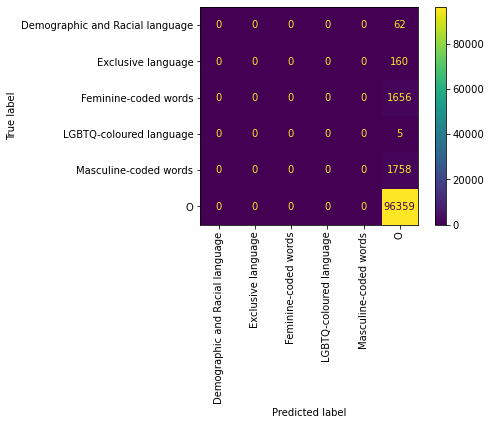

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.00      0.00      0.00      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       0.96      1.00      0.98     96359

                       accuracy                           0.96    100000
                      macro avg       0.16      0.17      0.16    100000
                   weighted avg       0.93      0.96      0.95    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Evaluation Neural network MLP

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("MLP")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [26]:
%%time

# Naive Bayes

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = GaussianNB()
scores_NB = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NB_avg_precision = mean(scores_NB['test_precision_macro'])
NB_avg_recall = mean(scores_NB['test_recall_macro'])
NB_avg_f1 = mean(scores_NB['test_f1_macro'])

print(NB_avg_precision)
print(NB_avg_recall)
print(NB_avg_f1)

# Model fit
clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Pr

0.11970472004188243
0.16667446151773477
0.005982920730818852
CPU times: user 4.21 s, sys: 3.83 s, total: 8.05 s
Wall time: 10.6 s


GaussianNB()

In [26]:
# Optionally the data can be saved to create a checkpoint - NB

import pickle

f = open('glove_nb.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('glove_nb.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.0166
Precision: 0.16942677707108286
Recall: 0.16667358523853507
F1_score: 0.005444128152409039


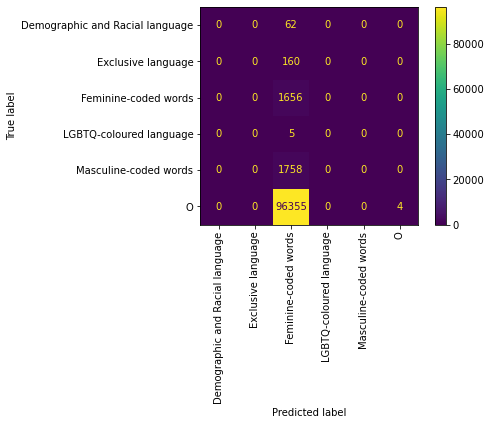

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.00      0.00        62
             Exclusive language       0.00      0.00      0.00       160
           Feminine-coded words       0.02      1.00      0.03      1656
        LGBTQ-coloured language       0.00      0.00      0.00         5
          Masculine-coded words       0.00      0.00      0.00      1758
                              O       1.00      0.00      0.00     96359

                       accuracy                           0.02    100000
                      macro avg       0.17      0.17      0.01    100000
                   weighted avg       0.96      0.02      0.00    100000



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
# Evaluation Naive Bayes

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("NB")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [41]:
results = pd.DataFrame(zip(classifier, accuracy, precision, recall, f1), columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
results = results.sort_values(by = "F1-score", ascending = False)

f = open('glove_results.pckl', 'wb')
pickle.dump(results, f)
f.close()

f = open('glove_results.pckl', 'rb')
results = pickle.load(f)
f.close()

print(results)

  Classifier  Accuracy  Precision    Recall  F1-score
3         DT   0.99623   0.925848  0.891740  0.899967
4         RF   0.98696   0.732725  0.656071  0.688036
2         LR   0.96359   0.160598  0.166667  0.163576
5        MLP   0.96359   0.160598  0.166667  0.163576
0   Baseline   0.16914   0.167265  0.172979  0.059258
1        SVM   0.09381   0.169732  0.201642  0.042030
6         NB   0.01660   0.169427  0.166674  0.005444


In [42]:
# Save results dataframe

results.to_csv('glove_results.csv', index = False)